In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.__version__

'1.26.4'

# Getting the data ready

In [295]:
### Importing the data

import os
data_dir = os.getcwd() + "/data"
train_dir = data_dir + "/train.csv"
test_dir = data_dir + "/test.csv"

train_size, test_size = os.path.getsize(train_dir), os.path.getsize(test_dir)
train_size, test_size = train_size / (1024*1024), test_size / (1024*1024)
train_size, test_size = round(train_size, 2), round(test_size, 2)
print(f"Train size: {train_size} MB | Test size: {test_size} MB")

Train size: 104.56 MB | Test size: 17.46 MB


In [3]:
### Creating the dataframes

train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)
len(train_df), len(test_df)

(60000, 10000)

In [4]:
### Get the split size of the data (%)

print(f"Split size:")
print(f"Train data: {round(len(train_df) / (len(train_df) + len(test_df)) * 100, 2)}%")
print(f"Test data: {round(len(test_df) / (len(train_df) + len(test_df)) * 100, 2)}%")

Split size:
Train data: 85.71%
Test data: 14.29%


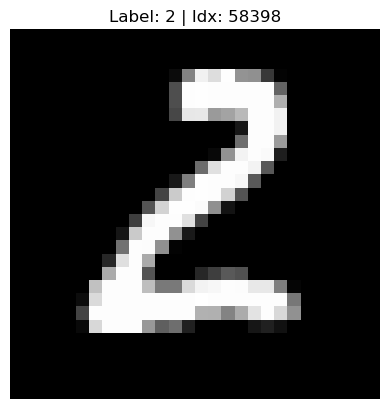

In [5]:
### Sample some random images from the data

import random
#random.seed(42)
idx = random.randint(0, len(train_df))
img, label = train_df.drop(["label"], axis = 1).iloc[idx].to_numpy(), train_df["label"].iloc[idx]
img = img.reshape(28, 28)

plt.imshow(img, cmap="grey")
plt.title(f"Label: {label} | Idx: {idx}")
plt.axis(False);

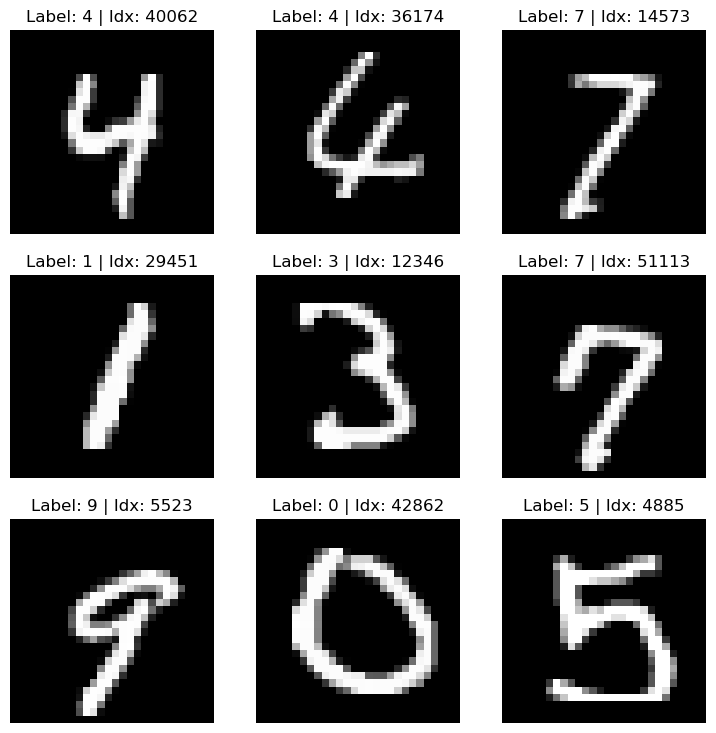

In [6]:
### Plotting 9 images with their labels

idxes = random.sample(range(0, len(train_df)), k = 9)
fig, axes = plt.subplots(figsize = (9, 9), nrows = 3, ncols = 3)
axes = axes.flatten()
for idx, ax in zip(idxes, axes):
    img, label = train_df.drop(["label"], axis = 1).iloc[idx].to_numpy(), train_df["label"].iloc[idx]
    img = img.reshape(28, 28)
    
    ax.imshow(img, cmap="grey")
    ax.set_title(f"Label: {label} | Idx: {idx}")
    ax.axis(False);

In [324]:
### Split the df's into features and labels

X_train, y_train = train_df.drop(["label"], axis=1), train_df["label"]
X_test, y_test = test_df.drop(["label"], axis=1), test_df["label"]
print(f"Data split into features and labels: {len(X_train), len(y_train), len(X_test), len(y_test)}")

### Normalize the data

print(f"\nOld pixel range: {min(X_train.iloc[0]), max(X_train.iloc[0])}")
X_train = X_train/255
X_test = X_test / 255
print(f"New pixel range: {min(X_train.iloc[0]), max(X_train.iloc[0])}")

### Transpose the feature matrix

"""print(f"\nShape before transpose: {X_train.shape}, {X_test.shape}")
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T
print(f"Shape after transpose: {X_train.shape}, {X_test.shape}")"""

Data split into features and labels: (60000, 60000, 10000, 10000)

Old pixel range: (0, 255)
New pixel range: (0.0, 1.0)


'print(f"\nShape before transpose: {X_train.shape}, {X_test.shape}")\nX_train = X_train.T\nX_test = X_test.T\ny_train = y_train.T\ny_test = y_test.T\nprint(f"Shape after transpose: {X_train.shape}, {X_test.shape}")'

In [325]:
### Convert the data into np-arrays
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

In [330]:
X_train[:32, :].shape, y_train[5]

((32, 784), 2)

# Modeling

## Classes

In [491]:
### Linear layer for the model
class Linear():
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 bias: bool = True,
                 seed: int = None):
        ### Create the weights and biases
        np.random.seed(seed)
        self.weights = np.random.rand(out_features, in_features) * 0.01
        self.bias = np.zeros(out_features) if bias else None
        ### Track the grad's of the weights and the biases
        self.weights_grad = np.zeros_like(self.weights)
        self.bias_grad = np.zeros_like(self.bias) if self.bias is not None else None
        
    def forward(self, x):
        """
        Performs a forward pass on the linear layer,
        and returns the output of the layer.
        """
        #print(f"Linear layer input shape: {x.shape}")
        self.input = x
        x = x @ self.weights.T
        #print(f"Linear layer output shape: {x.shape}")
        if self.bias is not None:
            x = x + self.bias
        return x

    def backward(self,
                 grad_output):
        """
        Performs the backward pass for the linear layer

        Args:
            grad_output - grad of the loss with respect to this layer's output
        """
        ### Error handling
        if grad_output is None:
            raise ValueError("grad_output cannot be None")
        ### dL/dW = (dL/dY).T @ X
        #self.weights_grad = grad_output[:, None] @ self.input[None, :]
        self.weights_grad = grad_output.T @ self.input
        ### dL/db = (dL/dY).sum
        if self.bias is not None:
            self.bias_grad = np.sum(grad_output, axis = 0)
        ### dL/dX = dL/dY @ W
        grad_input = grad_output @ self.weights
        return grad_input
        
    def parameters(self):
        num_weights = self.weights.size
        num_bias = self.bias.size
        return num_weights + num_bias

In [399]:
### Creating a few activation functions
class ReLU():
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad_input = grad_output * (self.input > 0)
        return grad_input
    
    def parameters(self):
        return None

class Softmax():
    def forward(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # Numerical stability trick
        self.output = exps / np.sum(exps, axis=1, keepdims=True)  # Ensure sum is over correct axis
        return self.output

    def backward(self, grad_output):
        return grad_output  # Softmax doesn't change gradient during backpropagation

    def parameters(self):
        return None

In [297]:
class Sequential():
    def __init__(self,
                 layers: list,
                 lr: float = 1e-3,
                 name: str = "Sequential model"):
        """
        Initializes the layers of the model
        """
        self.layers = layers
        self.lr = lr
        self.name = name
        
    def forward(self, x):
        """
        Performs forward propagation and returns the output of the model
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self,
                 loss_grad):
        """
        Performs the backward pass on the model's parameters,
        and updates the weights of the model
        """
        ### Perform the backward pass
        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def update_params(self):
        ### Update weights and biases using gradient descent
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.weights = layer.weights - (self.lr * layer.weights_grad)
                if layer.bias is not None:
                    layer.bias = layer.bias - (self.lr * layer.bias_grad)
            
        
    def summary(self):
        """
        Prints the model's layers and their parameters
        """
        print(f"Model: {self.name}\n")
        print(f"Layer name\t| Num params")
        print(f"---------------\t| ---------")
        sum = 0
        for layer in self.layers:
            print(f"{layer.__class__.__name__}\t\t| {layer.parameters()}")
            sum += layer.parameters() if layer.parameters() is not None else 0
        print(f"Total params: {sum}")

In [358]:
### Loss functions
class CrossEntropyLoss():
    def __init__(self,
                 batch_size: int = None):
        self.y_pred = None
        self.y_true = None
        self.batch_size = batch_size
        
    def __call__(self, y_pred, y_true):
        """
        Calculates the loss given the True and Predicted values,
        and returns it.
        """
        self.y_pred = y_pred
        self.y_true = y_true
        ### Clip predictions to prevent log(0)
        y_pred = np.clip(y_pred, 1e-10, 1.0-1e-10)
        ### Calculate cross-entropy loss
        loss = -np.sum(y_true * np.log(y_pred))
        if self.batch_size is not None:
             loss /= self.batch_size
        return loss

    def backward(self):
        """
        Calculates the loss with respect to the True and Predicted values,
        and returns it.
        """
        grad = (self.y_pred - self.y_true)
        if self.batch_size is not None:
            grad /= self.batch_size
        return grad
    
    def parameters(self):
        return None

class SparseCrossEntropyLoss():
    def __init__(self, batch_size: int = None):
        self.y_pred = None
        self.y_true = None
        self.batch_size = batch_size
        
    def __call__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        y_pred = np.clip(y_pred, 1e-10, 1.0 - 1e-10)
        
        # Calculate sparse cross-entropy loss
        loss = -np.log(y_pred[np.arange(len(y_true)), y_true])
        
        if self.batch_size is not None:
            loss = np.sum(loss) / self.batch_size
        else:
            loss = np.sum(loss) / len(y_true)
        
        return loss

    def backward(self):
        grad = self.y_pred.copy()
        grad[np.arange(len(self.y_true)), self.y_true] -= 1
        
        if self.batch_size is not None:
            grad /= self.batch_size
        
        return grad
    
    def parameters(self):
        return None

In [243]:
Sequential([
    Linear(in_features = 28*28, out_features = 3),
    Linear(in_features = 3, out_features = 3),
    ReLU(),
    Softmax()
]).forward(np.random.rand(28*28))

array([0.33597436, 0.33631166, 0.32771398])

## Model 1

### Model testing

In [290]:
model_1 = Sequential([
    Linear(in_features = 28*28, out_features = 10),
    ReLU(),
    Linear(in_features = 10, out_features = 10),
    Softmax(),
])
model_1.summary()

Layer name	| Num params
---------------	| ---------
Linear		| 7850
ReLU		| None
Linear		| 110
Softmax		| None
Total params: 7960


In [291]:
### Sample data
y_true = np.random.randint(0, 2, size = 10)
x = np.random.rand(28**2)

In [292]:
# Forward propagation
y1 = model_1.forward(x)

# Back propagation
loss_fn = CrossEntropyLoss()
loss = loss_fn(y1, y_true)
loss_grad = loss_fn.backward()
print(f"Loss = {loss}")
model_1.backward(loss_grad)
model_1.update_params()

# Forward propagation to verify backward propagation
y2 = model_1.forward(x)

print()
print(y1)
print(y2)
print()
loss = loss_fn(y2, y_true)
print(f"Loss = {loss}")
print()
print(y_true)

Loss = 9.206893010579723

[0.10036342 0.10331771 0.09811664 0.09761191 0.10175439 0.09912883
 0.10364958 0.09728067 0.10114988 0.09762697]
[0.09874564 0.10580008 0.10048175 0.09604404 0.10420112 0.09753658
 0.10197623 0.09963013 0.09952211 0.09606233]

Loss = 9.11170630843505

[0 1 1 0 1 0 0 1 0 0]


In [293]:
for epoch in range(10):
    y = model_1.forward(x)
    loss = loss_fn(y_pred = y, y_true = y_true)
    loss_grad = loss_fn.backward()
    print(f"Epoch: {epoch+1} | Loss: {loss}")
    model_1.backward(loss_grad)
    model_1.update_params()

Epoch: 1 | Loss: 9.11170630843505
Epoch: 2 | Loss: 9.017743149039026
Epoch: 3 | Loss: 8.924728389027747
Epoch: 4 | Loss: 8.832411143752395
Epoch: 5 | Loss: 8.740564241141186
Epoch: 6 | Loss: 8.648983918739372
Epoch: 7 | Loss: 8.557489745481657
Epoch: 8 | Loss: 8.465924747785765
Epoch: 9 | Loss: 8.374155716877393
Epoch: 10 | Loss: 8.28207367081823


### Creating, training, inferencing

In [508]:
### Creating the model
model_1 = Sequential(
    [Linear(in_features = 28**2, out_features = 10),
     ReLU(),
     Linear(in_features = 10, out_features = 10),
     Softmax()],
    lr = 1e-2,
    name = "model_1"
)

model_1.summary()

Model: model_1

Layer name	| Num params
---------------	| ---------
Linear		| 7850
ReLU		| None
Linear		| 110
Softmax		| None
Total params: 7960


In [509]:
### Creating the accuracy function
def accuracy_fn(y_pred, y_true):
    """
    Returns the accuracy (0-1) from the pred and true lists.
    """
    return np.sum(y_pred == y_true) / len(y_pred)

### Testing the function
accuracy_fn(np.array([1, 0, 6, 9]), np.array([1, 0, 6, 8]))

0.75

In [510]:
# Adjust the training loop to ensure correct shapes
epochs = 50
batch_size = 32
loss_fn = SparseCrossEntropyLoss(batch_size=batch_size)
#loss_fn = CrossEntropyLoss(batch_size=batch_size)

for epoch in range(epochs):
    permutation = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train[permutation]
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train_shuffled[i:i+batch_size].reshape(batch_size, 28*28)
        y_batch = y_train_shuffled[i:i+batch_size].flatten()
    
        y_pred = model_1.forward(X_batch)
        #print(y_pred.shape)
        #print(y_batch.shape)
        
        loss = loss_fn(y_pred=y_pred, y_true=y_batch)
        loss_grad = loss_fn.backward()
        #print(loss_grad.shape)
    
        model_1.backward(loss_grad)
        model_1.update_params()
    if (epoch+1) % 1 == 0:
        print(f"Epoch: {epoch + 1} | Loss: {loss:.4f} | Acc: {accuracy_fn(np.argmax(y_pred, axis = 1), y_batch)}")

Epoch: 1 | Loss: 1.3780 | Acc: 0.5625
Epoch: 2 | Loss: 0.3835 | Acc: 0.875
Epoch: 3 | Loss: 0.4266 | Acc: 0.875
Epoch: 4 | Loss: 0.5216 | Acc: 0.9375
Epoch: 5 | Loss: 0.3594 | Acc: 0.875
Epoch: 6 | Loss: 0.3139 | Acc: 0.875
Epoch: 7 | Loss: 0.2616 | Acc: 0.875
Epoch: 8 | Loss: 0.1959 | Acc: 0.90625
Epoch: 9 | Loss: 0.1396 | Acc: 0.96875
Epoch: 10 | Loss: 0.1900 | Acc: 0.9375
Epoch: 11 | Loss: 0.2453 | Acc: 0.9375
Epoch: 12 | Loss: 0.4070 | Acc: 0.78125
Epoch: 13 | Loss: 0.0855 | Acc: 0.96875
Epoch: 14 | Loss: 0.1768 | Acc: 0.9375
Epoch: 15 | Loss: 0.2008 | Acc: 0.9375
Epoch: 16 | Loss: 0.1421 | Acc: 0.96875
Epoch: 17 | Loss: 0.2933 | Acc: 0.90625
Epoch: 18 | Loss: 0.2025 | Acc: 0.96875
Epoch: 19 | Loss: 0.1875 | Acc: 0.9375
Epoch: 20 | Loss: 0.2857 | Acc: 0.875
Epoch: 21 | Loss: 0.0603 | Acc: 1.0
Epoch: 22 | Loss: 0.0951 | Acc: 0.96875
Epoch: 23 | Loss: 0.1276 | Acc: 0.9375
Epoch: 24 | Loss: 0.4144 | Acc: 0.84375
Epoch: 25 | Loss: 0.3459 | Acc: 0.9375
Epoch: 26 | Loss: 0.0781 | Acc: 0.

In [524]:
### Get model's evaluation on the full training data

y_preds = []
for sample, img in enumerate(X_train):
    img = img.reshape(1, -1)
    pred = model_1.forward(img)
    pred = pred.argmax(axis = 1)
    y_preds.append(pred[0])

print(accuracy_fn(y_preds, y_train))

0.94535


(10,)


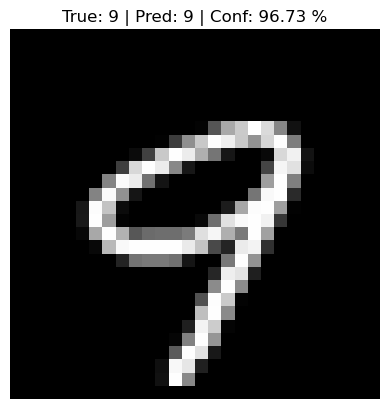

In [525]:
### Making predictions

idx = random.randint(0, len(X_train)-1)
img, label = X_train[idx, :], y_train[idx]
img = img.reshape(1, -1)
pred = model_1.forward(img)
print(pred[0].shape)

### Plot the image and prediction

img = img.reshape((28, 28))
plt.imshow(img,
           cmap = "grey")
plt.axis(False)
plt.title(f"True: {label} | Pred: {np.argmax(pred[0])} | Conf: {pred[0][np.argmax(pred)]*100:.2f} %");

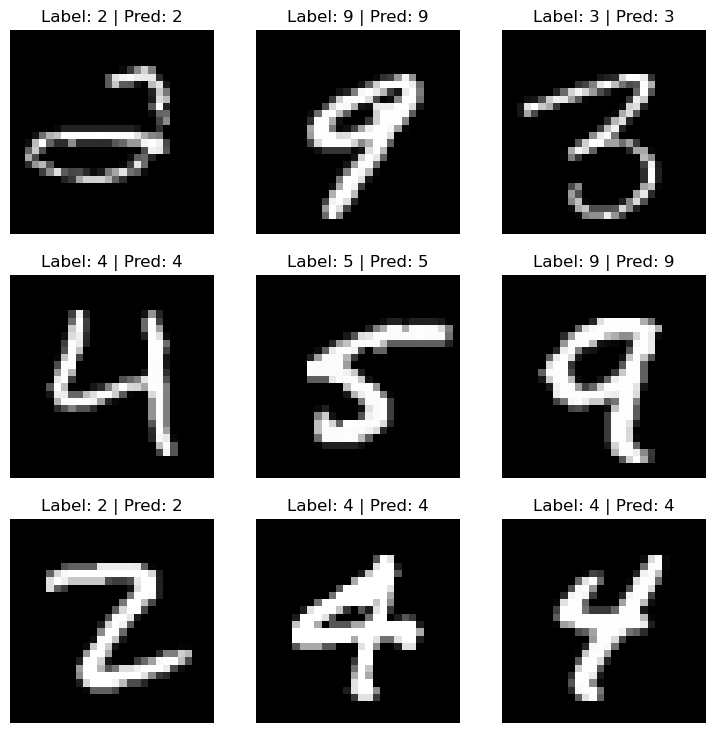

In [526]:
### Inference on 9 images

idxes = random.sample(range(0, len(train_df)), k = 9)
fig, axes = plt.subplots(figsize = (9, 9), nrows = 3, ncols = 3)
axes = axes.flatten()
for idx, ax in zip(idxes, axes):
    img, label = train_df.drop(["label"], axis = 1).iloc[idx].to_numpy(), train_df["label"].iloc[idx]
    img = img.reshape(1, -1)
    pred = model_1.forward(img)
    pred_lbl = pred.argmax()
    
    img = img.reshape(28, 28)
    ax.imshow(img, cmap="grey")
    ax.set_title(f"Label: {label} | Pred: {pred_lbl}")
    ax.axis(False);

In [531]:
### Convert into functions


def train_step(model,
               X_batch,
               y_batch):
    """
    Performs a full training epoch.
    Completes a forward pass, calculates the loss, performs the backward pass, updates the weights.
    And returns the loss of the model.
    """
    y_pred = model.forward(X_batch)
    y_pred_lbl = y_pred.argmax(axis = 1)
    loss = loss_fn(y_pred=y_pred, y_true=y_batch)
    accuracy = accuracy_fn(y_pred=y_pred_lbl, y_true=y_batch)
    loss_grad = loss_fn.backward()
    model.backward(loss_grad)
    model.update_params()
    return loss, accuracy

def test_step(model,
              X_batch,
              y_batch):
    y_pred = model.forward(X_batch)
    y_pred_lbl = y_pred.argmax(axis = 1)
    loss = loss_fn(y_pred=y_pred, y_true=y_batch)
    accuracy = accuracy_fn(y_pred=y_pred_lbl, y_true=y_batch)
    return loss, accuracy

def train(model,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs: int,
          batch_size: int = 32,
          print_freq: int = 1):
    for epoch in range(0, epochs):
        permutation = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        for i in range(0, len(X_train), batch_size):
            # Get batches
            X_batch = X_train_shuffled[i:i+batch_size].reshape(batch_size, 28*28)
            y_batch = y_train_shuffled[i:i+batch_size].flatten()
            # Train
            train_loss, train_acc = train_step(model, X_batch, y_batch)
            # Test
            test_loss, test_acc = test_step(model, X_batch, y_batch)
        if (epoch+1) % print_freq == 0:
            print(f"Epoch: {epoch + 1} | Train loss: {train_loss:.4f} | Train acc: {train_acc*100:.2f} %")

In [543]:
model_1 = Sequential([
    Linear(in_features = 28*28, out_features = 10),
    ReLU(),
    Linear(in_features = 10, out_features = 10),
    Softmax(),
], lr = 1e-3)
model_1.summary()
print()

train(model = model_1,
      X_train = X_train,
      y_train = y_train,
      X_test = X_test,
      y_test = y_test,
      epochs = 50,
      print_freq = 10)

Model: Sequential model

Layer name	| Num params
---------------	| ---------
Linear		| 7850
ReLU		| None
Linear		| 110
Softmax		| None
Total params: 7960

Epoch: 10 | Train loss: 1.1876 | Train acc: 65.62 %
Epoch: 20 | Train loss: 0.4047 | Train acc: 87.50 %
Epoch: 30 | Train loss: 0.3101 | Train acc: 87.50 %
Epoch: 40 | Train loss: 0.9663 | Train acc: 84.38 %
Epoch: 50 | Train loss: 0.4292 | Train acc: 90.62 %


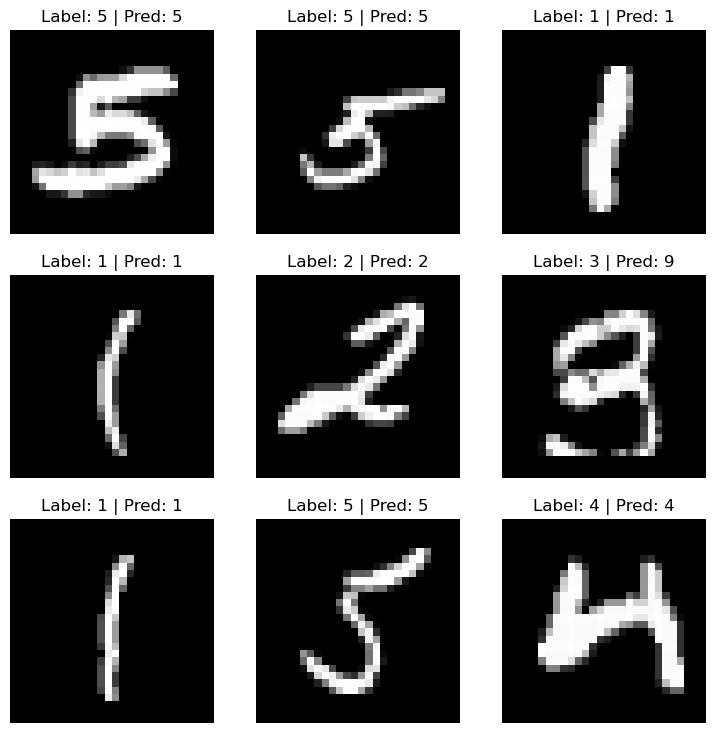

In [544]:
### Inference on 9 images

idxes = random.sample(range(0, len(train_df)), k = 9)
fig, axes = plt.subplots(figsize = (9, 9), nrows = 3, ncols = 3)
axes = axes.flatten()
for idx, ax in zip(idxes, axes):
    img, label = train_df.drop(["label"], axis = 1).iloc[idx].to_numpy(), train_df["label"].iloc[idx]
    img = img.reshape(1, -1)
    pred = model_1.forward(img)
    pred_lbl = pred.argmax()
    
    img = img.reshape(28, 28)
    ax.imshow(img, cmap="grey")
    ax.set_title(f"Label: {label} | Pred: {pred_lbl}")
    ax.axis(False);

## Model 2

In [545]:
### Testing the model using the TanH activation
class Tanh():
    def forward(self, x):
        ex = np.exp(x)
        e_x = 1/np.exp(x)
        self.output = (ex - e_x)/(ex + e_x)
        return self.output

    def backward(self, grad_output):
        grad_input = grad_output * (1 - self.output ** 2)
        return grad_input
        
    def parameters(self):
        return None

In [546]:
model_2 = Sequential([
    Linear(in_features = 28**2, out_features = 10),
    Tanh(),
    Linear(in_features = 10, out_features = 10),
    Softmax(),
], lr = 1e-3, name = "model_2")
model_2.summary()

Model: model_2

Layer name	| Num params
---------------	| ---------
Linear		| 7850
Tanh		| None
Linear		| 110
Softmax		| None
Total params: 7960


In [548]:
train(
    model = model_2,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    epochs = 50,
    batch_size = 32,
    print_freq = 10
)

Epoch: 10 | Train loss: 1.2742 | Train acc: 56.25 %
Epoch: 20 | Train loss: 0.7406 | Train acc: 78.12 %
Epoch: 30 | Train loss: 0.4374 | Train acc: 93.75 %
Epoch: 40 | Train loss: 0.3612 | Train acc: 90.62 %
Epoch: 50 | Train loss: 0.3345 | Train acc: 84.38 %


In [549]:
### Get model's evaluation on the full training data

y_preds = []
for sample, img in enumerate(X_train):
    img = img.reshape(1, -1)
    pred = model_2.forward(img)
    pred = pred.argmax(axis = 1)
    y_preds.append(pred[0])

print(accuracy_fn(y_preds, y_train))

0.9068833333333334


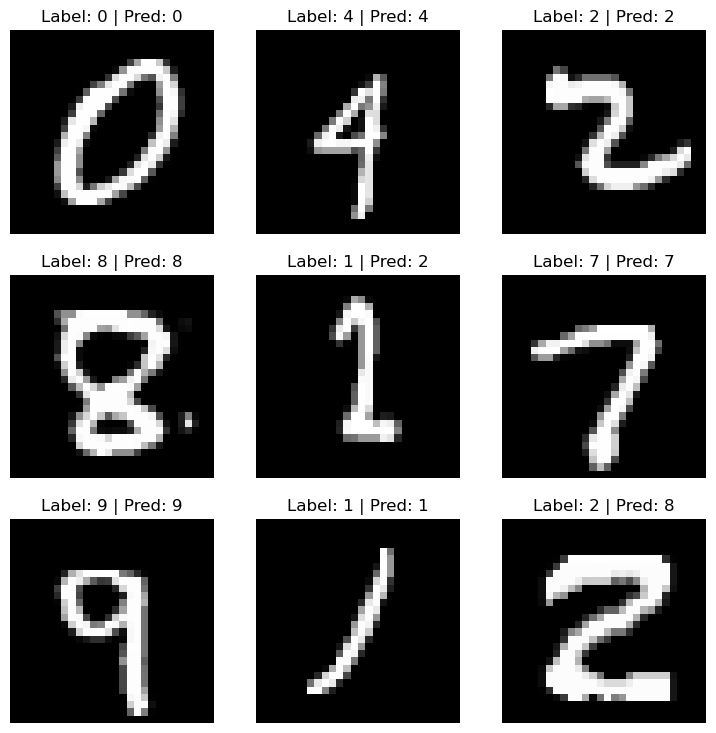

In [550]:
### Inference on 9 images

idxes = random.sample(range(0, len(train_df)), k = 9)
fig, axes = plt.subplots(figsize = (9, 9), nrows = 3, ncols = 3)
axes = axes.flatten()
for idx, ax in zip(idxes, axes):
    img, label = train_df.drop(["label"], axis = 1).iloc[idx].to_numpy(), train_df["label"].iloc[idx]
    img = img.reshape(1, -1)
    pred = model_1.forward(img)
    pred_lbl = pred.argmax()
    
    img = img.reshape(28, 28)
    ax.imshow(img, cmap="grey")
    ax.set_title(f"Label: {label} | Pred: {pred_lbl}")
    ax.axis(False);

## Model 3

In [562]:
model_3 = Sequential([
    Linear(in_features = 28**2, out_features = 64),
    ReLU(),
    Linear(in_features = 64, out_features = 10),
    Softmax()
], lr = 1e-3, name = "model_3")
model_3.summary()

Model: model_3

Layer name	| Num params
---------------	| ---------
Linear		| 50240
ReLU		| None
Linear		| 650
Softmax		| None
Total params: 50890


In [563]:
train(
    model = model_3,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    epochs = 50,
    batch_size = 32,
    print_freq = 10
)

Epoch: 10 | Train loss: 0.5355 | Train acc: 93.75 %
Epoch: 20 | Train loss: 0.6669 | Train acc: 78.12 %
Epoch: 30 | Train loss: 0.4120 | Train acc: 87.50 %
Epoch: 40 | Train loss: 0.2284 | Train acc: 93.75 %
Epoch: 50 | Train loss: 0.1541 | Train acc: 96.88 %


In [565]:
### Get model's evaluation on the full training data

y_preds = []
for sample, img in enumerate(X_train):
    img = img.reshape(1, -1)
    pred = model_3.forward(img)
    pred = pred.argmax(axis = 1)
    y_preds.append(pred[0])

print(accuracy_fn(y_preds, y_train))

0.9140833333333334


# PureTorch

## Verification of PureTorch

In [566]:
!pip install "git+https://github.com/Dristro/PureTorch"

  Cloning https://github.com/Dristro/PureTorch to /private/var/folders/pc/8b_z8xc17d33jmyzppszfkb00000gn/T/pip-req-build-nwmvzpa3
  Running command git clone --filter=blob:none --quiet https://github.com/Dristro/PureTorch /private/var/folders/pc/8b_z8xc17d33jmyzppszfkb00000gn/T/pip-req-build-nwmvzpa3
  Resolved https://github.com/Dristro/PureTorch to commit 87fc045e7b04b9459139f2bee6ae164eda4ffb57
  Preparing metadata (setup.py) ... done
  Created wheel for PureTorch: filename=PureTorch-0.1-py3-none-any.whl size=3876 sha256=0e52e53ea1a0e1e7cb71a674f5ec29b967f687260b9a3f7d0ee06fae19075251
  Stored in directory: /private/var/folders/pc/8b_z8xc17d33jmyzppszfkb00000gn/T/pip-ephem-wheel-cache-5m6b18xk/wheels/1e/b4/dc/dcb43b5a7c2f8f0f427d21ff6b0e966ebc7aac4ab4073365bd
Successfully built PureTorch


In [567]:
import PureTorch
PureTorch.__version__

'0.1.0'

In [573]:
model_4 = PureTorch.layers.Sequential([
    PureTorch.layers.Linear(in_features = 28**2, out_features = 10),
    PureTorch.activations.ReLU(),
    PureTorch.layers.Linear(in_features = 10, out_features = 10),
    PureTorch.activations.Softmax(),
], lr = 1e-3, name = "PureTorch model - model_4")

model_4.summary()

Model: PureTorch model - model_4

Layer name	| Num params
---------------	| ---------
Linear		| 7850
ReLU		| None
Linear		| 110
Softmax		| None
Total params: 7960


In [574]:
train(
    model = model_4,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    epochs = 25
)

Epoch: 1 | Train loss: 2.2876 | Train acc: 6.25 %
Epoch: 2 | Train loss: 2.2177 | Train acc: 18.75 %
Epoch: 3 | Train loss: 2.1162 | Train acc: 21.88 %
Epoch: 4 | Train loss: 1.9901 | Train acc: 34.38 %
Epoch: 5 | Train loss: 1.9341 | Train acc: 40.62 %
Epoch: 6 | Train loss: 1.8154 | Train acc: 56.25 %
Epoch: 7 | Train loss: 1.3866 | Train acc: 75.00 %
Epoch: 8 | Train loss: 1.3100 | Train acc: 62.50 %
Epoch: 9 | Train loss: 1.1262 | Train acc: 65.62 %
Epoch: 10 | Train loss: 0.8769 | Train acc: 90.62 %
Epoch: 11 | Train loss: 0.8851 | Train acc: 75.00 %
Epoch: 12 | Train loss: 0.7201 | Train acc: 75.00 %
Epoch: 13 | Train loss: 0.6698 | Train acc: 81.25 %
Epoch: 14 | Train loss: 0.7123 | Train acc: 75.00 %
Epoch: 15 | Train loss: 0.9436 | Train acc: 68.75 %
Epoch: 16 | Train loss: 0.4290 | Train acc: 87.50 %
Epoch: 17 | Train loss: 0.3744 | Train acc: 87.50 %
Epoch: 18 | Train loss: 0.3599 | Train acc: 87.50 %
Epoch: 19 | Train loss: 0.4606 | Train acc: 81.25 %
Epoch: 20 | Train loss

In [576]:
### Get model's evaluation on the full training data

y_preds = []
for sample, img in enumerate(X_train):
    img = img.reshape(1, -1)
    pred = model_4.forward(img)
    pred = pred.argmax(axis = 1)
    y_preds.append(pred[0])

print(accuracy_fn(y_preds, y_train))

0.8868333333333334


## Testing PureTorch dev

In [587]:
!pip uninstall -y PureTorch

Found existing installation: PureTorch 0.1
Uninstalling PureTorch-0.1:
  Successfully uninstalled PureTorch-0.1


In [588]:
!pip install "git+https://github.com/Dristro/PureTorch.git@dev"

  Cloning https://github.com/Dristro/PureTorch.git (to revision dev) to /private/var/folders/pc/8b_z8xc17d33jmyzppszfkb00000gn/T/pip-req-build-3cs5tfe3
  Running command git clone --filter=blob:none --quiet https://github.com/Dristro/PureTorch.git /private/var/folders/pc/8b_z8xc17d33jmyzppszfkb00000gn/T/pip-req-build-3cs5tfe3
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  branch 'dev' set up to track 'origin/dev'.
  Resolved https://github.com/Dristro/PureTorch.git to commit bbc49125c7fdb34fe66cd398c70534adc1595d10
  Preparing metadata (setup.py) ... done
  Created wheel for PureTorch: filename=PureTorch-0.1-py3-none-any.whl size=4713 sha256=64ae924d71eb47d9e7ed09b0d68d83aa17d461426494ad64dedfe134849d3582
  Stored in directory: /private/var/folders/pc/8b_z8xc17d33jmyzppszfkb00000gn/T/pip-ephem-wheel-cache-cc3732ch/wheels/ca/5f/b3/276efa6ab3d8e469c954e6234d5c2927e66ddb370dd2ce8657
Successfully built PureTorch


In [589]:
import PureTorch
PureTorch.__version__

'0.1.0'

In [591]:
model_5 = PureTorch.layers.Sequential([
    PureTorch.layers.Linear(28**2, 10),
    PureTorch.activations.ReLU(),
    PureTorch.layers.Linear(10, 10),
    PureTorch.activations.Softmax()
], name = "Testing train inside of Sequential")

model_5.summary()

Model: Testing train inside of Sequential

Layer name	| Num params
---------------	| ---------
Linear		| 7850
ReLU		| None
Linear		| 110
Softmax		| None
Total params: 7960


In [593]:
model_5